In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random



from collections import Counter
from scipy.stats import mode

import sys
import os

# Add the directory containing 'aug.py' to the Python path
sys.path.append(os.path.abspath(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\day7to10_simclr_pred"))
from aug import one_Original,two_Ori_Hori_blur,three_Orig_Veri_sharp,four_Orig_verihori_sharp_blur,five_only_D10_Hori,six_only_D10_veri,seven_D10_verihori,ate_only_D7_Hori,nine_only_D7_veri,ten_D7_verihori,eleven_Orig_R90_sharp_blur,twelve_Orig_R270_sharp_blur,thirteen_Orig_HoriR90_sharp_blur,fourteen_Orig_HoriR270_sharp_blur,fifteen_D7_R90,sixteen_D7_R270,seventeen_D7_HoriR90,ateen_D7_HoriR270,ninteen_D10_R90,twenty_D10_R270,twentyone_D10_HoriR90,

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\SimCLR_base_models\ohnecontrast_balancedResize_simclr_modelepoch245.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_23808\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
from torchvision.transforms import Resize, RandomHorizontalFlip,RandomVerticalFlip
import random
import torchvision.transforms.functional as TF

In [8]:
# Specify paths for both day7 and day10 folders

#train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
#train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'


#train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day7'
#train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day10'

train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61'
train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61'

#train_dataset = one_Original(train_day7_dir, train_day10_dir) 
#train_dataset = two_Ori_Hori_blur(train_day7_dir, train_day10_dir) 
# 3 train_dataset = three_Orig_Veri_sharp(train_day7_dir, train_day10_dir) 
# 4 train_dataset = four_Orig_verihori_sharp_blur(train_day7_dir, train_day10_dir) 
# 5 train_dataset = five_only_D10_Hori(train_day7_dir, train_day10_dir) 
# 6 train_dataset = six_only_D10_veri(train_day7_dir, train_day10_dir) 
# 7 train_dataset = seven_D10_verihori(train_day7_dir, train_day10_dir) 
# 8 train_dataset = ate_only_D7_Hori(train_day7_dir, train_day10_dir) 
# 9 train_dataset = nine_only_D7_veri(train_day7_dir, train_day10_dir) 
# 10 train_dataset = ten_D7_verihori(train_day7_dir, train_day10_dir) 
# 11 train_dataset = eleven_Orig_R90_sharp_blur(train_day7_dir, train_day10_dir) 
# 12 train_dataset = twelve_Orig_R270_sharp_blur(train_day7_dir, train_day10_dir) 
# 13 train_dataset = thirteen_Orig_HoriR90_sharp_blur(train_day7_dir, train_day10_dir) 
# 14 train_dataset = fourteen_Orig_HoriR270_sharp_blur(train_day7_dir, train_day10_dir)
# 15 train_dataset = fifteen_D7_R90(train_day7_dir, train_day10_dir)
# 16 train_dataset = sixteen_D7_R270(train_day7_dir, train_day10_dir)
# 17 train_dataset = seventeen_D7_HoriR90(train_day7_dir, train_day10_dir)
# 18 train_dataset = ateen_D7_HoriR270(train_day7_dir, train_day10_dir)
# 19 train_dataset = ninteen_D10_R90(train_day7_dir, train_day10_dir)
# 20 train_dataset = twenty_D10_R270(train_day7_dir, train_day10_dir)
# 21 train_dataset = twentyone_D10_HoriR90(train_day7_dir, train_day10_dir)
# train_dataset = twentytwo_D10_HoriR270(train_day7_dir, train_day10_dir)


In [9]:
batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

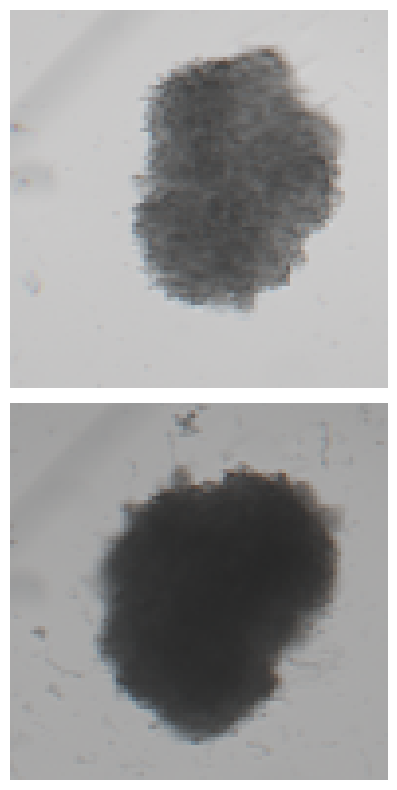

In [10]:
# Retrieve one dataset sample
#day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]
day7_img, day10_img= train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
#plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
#plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


In [12]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    
    for batch_day7_imgs, batch_day10_imgs in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats


import random
import torchvision.transforms.functional as TF

class ImageDataset(Dataset):
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}

        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."
        self.resize = Resize((96, 96))

        # Horizontal flip
        #self.Horiflip = RandomHorizontalFlip(p=1)
        self.Veriflip = RandomVerticalFlip(p=1)

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        filename = self.common_files[idx]
        day7_img_path = self.day7_files[filename]
        day10_img_path = self.day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize and convert both images
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        # Resize the images
        day7_img = self.resize(day7_img)
        day10_img = self.resize(day10_img)

        # Apply horizontal flip
        day7_img = self.Veriflip(day7_img)
        day10_img = self.Veriflip(day10_img)

        # Synchronized augmentations
        # 1. RandomAdjustSharpness
        sharpness_factor = 2.0
        day7_aug = TF.adjust_sharpness(day7_img, sharpness_factor)
        day10_aug = TF.adjust_sharpness(day10_img, sharpness_factor)

        # 2. GaussianBlur
        #sigma = random.uniform(0.1, 1)  # Randomly choose sigma in the range [0.1, 1]
        #day7_aug = TF.gaussian_blur(day7_aug, kernel_size=5, sigma=sigma)
        #day10_aug = TF.gaussian_blur(day10_aug, kernel_size=5, sigma=sigma)

        # 3. ColorJitter (brightness adjustment)
        brightness_factor = random.uniform(0.85, 1.15)  # Brightness factor between 0.85 and 1.15
        day7_aug = TF.adjust_brightness(day7_aug, brightness_factor)
        day10_aug = TF.adjust_brightness(day10_aug, brightness_factor)

        return day7_aug, day10_aug
        #return day7_img, day10_img,day7_aug,day10_aug
   
# Specify paths for both day7 and day10 folders
train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'


# Create the dataset
train_dataset = ImageDataset(train_day7_dir, train_day10_dir) 


batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=1),
    transforms.RandomApply([
        transforms.GaussianBlur(5, sigma=(0.1, 1)) #std p= 0.5 .simclr randomly sample σ ∈ [0.1, 2.0], and the kernel size is set to be 10% of the image height/width. # 9 is the 10% of hight (96) since resizecrop to 96 already loosing info, i wanna reduce bluring. less kernal size and less  less blur
    ], p=1),
    transforms.RandomApply([
    transforms.ColorJitter(brightness=0.15)
    ], p=1), 

])


# Retrieve one dataset sample
day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]
#day7_img, day10_img= train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


# horizontal flip . only one type of transformation. it doesn't matter left or right.

# Retrieve one dataset sample
day7_img, day10_img,day7_flip,day10_flip = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_flip.permute(1, 2, 0).numpy()
day10_flip_np = day10_flip.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


# Retrieve one dataset sample
day7_img, day10_img,day7_flip,day10_flip = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_flip.permute(1, 2, 0).numpy()
day10_flip_np = day10_flip.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


# Retrieve one dataset sample
day7_img, day10_img,day7_flip,day10_flip = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_flip.permute(1, 2, 0).numpy()
day10_flip_np = day10_flip.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


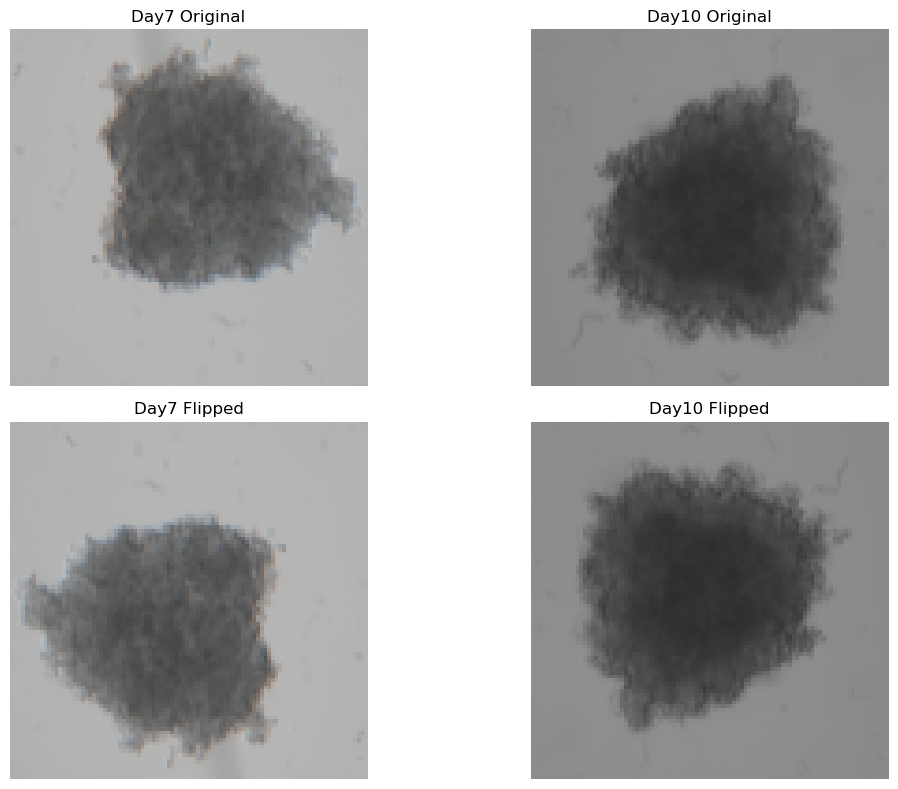

In [29]:
# Retrieve one dataset sample
day7_img, day10_img,day7_flip,day10_flip = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_flip.permute(1, 2, 0).numpy()
day10_flip_np = day10_flip.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


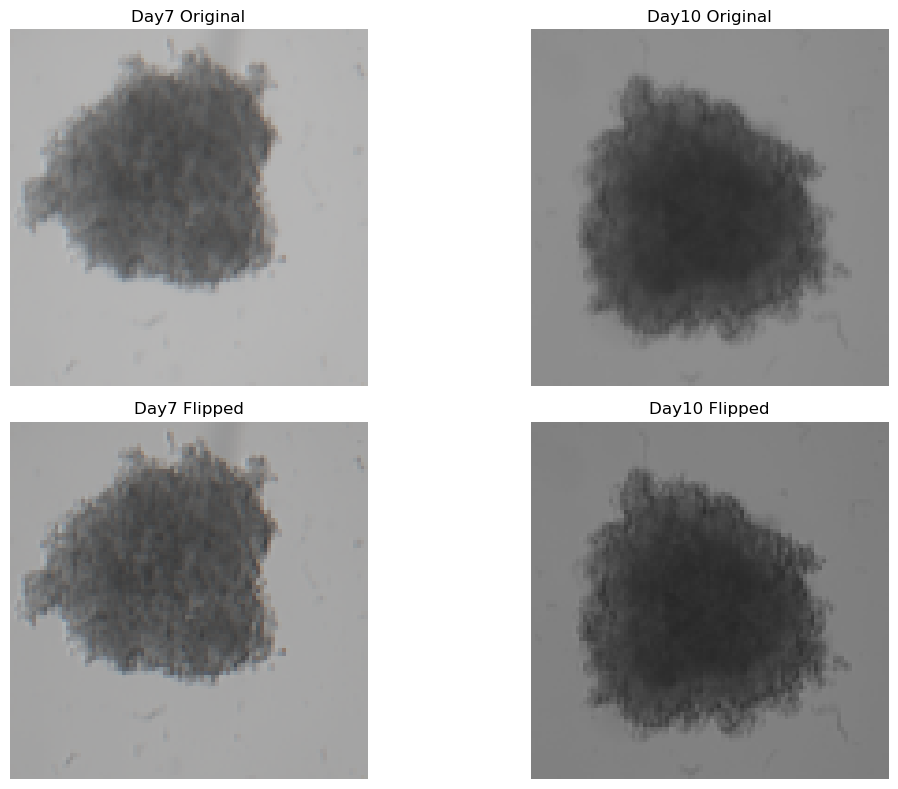

In [17]:
# Retrieve one dataset sample
day7_img, day10_img,day7_aug,day10_aug = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_aug.permute(1, 2, 0).numpy()
day10_flip_np = day10_aug.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


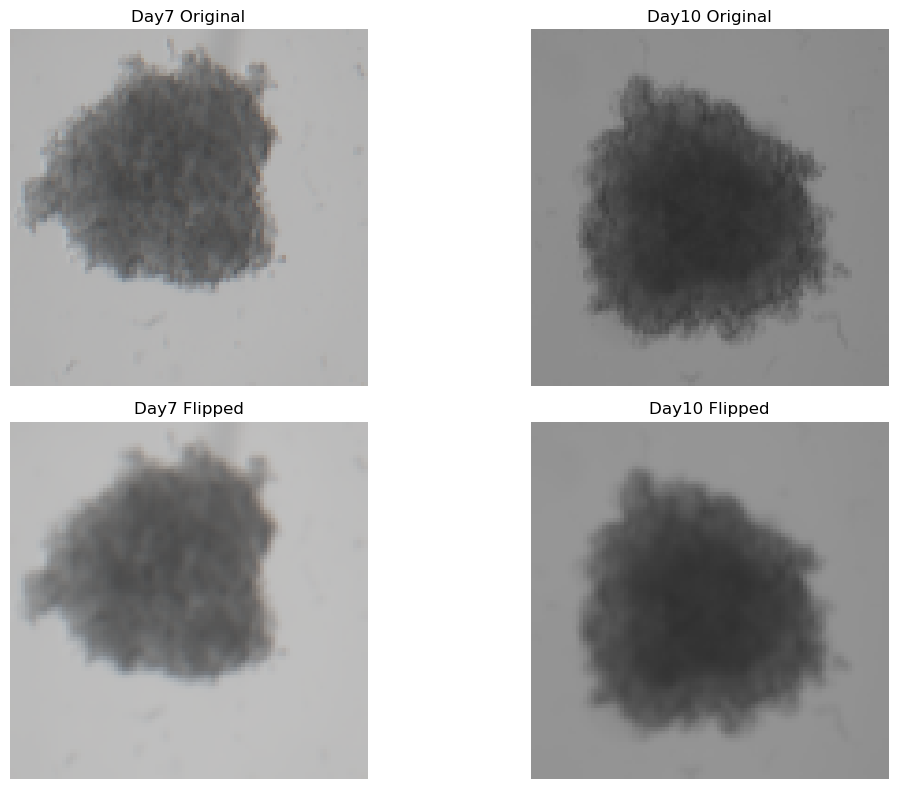

In [20]:
# Retrieve one dataset sample
day7_img, day10_img,day7_aug,day10_aug = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_flip_np = day7_aug.permute(1, 2, 0).numpy()
day10_flip_np = day10_aug.permute(1, 2, 0).numpy()

# Display images
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title("Day7 Original")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 2)
plt.imshow(day10_img_np)
plt.title("Day10 Original")
plt.axis("off")

# Day7 Flipped
plt.subplot(2, 2, 3)
plt.imshow(day7_flip_np)
plt.title("Day7 Flipped")
plt.axis("off")

# Day10 Flipped
plt.subplot(2, 2, 4)
plt.imshow(day10_flip_np)
plt.title("Day10 Flipped")
plt.axis("off")

plt.tight_layout()
plt.show()


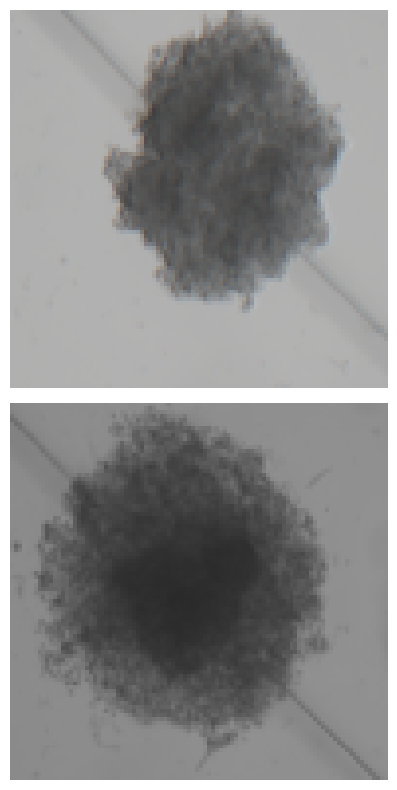

In [17]:
# Retrieve one dataset sample
#day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]
day7_img, day10_img= train_dataset[3]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
#plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
#plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    
    for batch_day7_imgs, batch_day10_imgs in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats


In [15]:
# Extract features from the training dataset
cond7_130_orig, cond10_130_orig = prepare_data_features(simclr_model, train_loader)

 11%|█         | 1/9 [00:01<00:12,  1.51s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:02<00:09,  1.35s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:03<00:07,  1.28s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:05<00:06,  1.26s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:06<00:05,  1.30s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:07<00:03,  1.31s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:09<00:02,  1.32s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:10<00:01,  1.28s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [16]:
# Save training features
torch.save(cond7_130_orig, 'cond7_130_orig.pt')
torch.save(cond10_130_orig, 'cond10_130_orig.pt')

In [13]:
# Extract features from the training dataset
sd7, sd10 = prepare_data_features(simclr_model, train_loader)

 50%|█████     | 1/2 [00:01<00:01,  1.73s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

Day 7 Batch features shape: torch.Size([13, 512])
Day 10 Batch features shape: torch.Size([13, 512])
Day 7 Features shape after concatenation: torch.Size([29, 512])
Day 10 Features shape after concatenation: torch.Size([29, 512])


In [14]:
# Save training features
torch.save(sd7, 'sd7.pt')
torch.save(sd10, 'sd10.pt')

In [12]:
# Extract features from the training dataset
exploded38_day7, exploded38_day10 = prepare_data_features(simclr_model, train_loader)

 33%|███▎      | 1/3 [00:01<00:03,  1.69s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Day 7 Batch features shape: torch.Size([6, 512])
Day 10 Batch features shape: torch.Size([6, 512])
Day 7 Features shape after concatenation: torch.Size([38, 512])
Day 10 Features shape after concatenation: torch.Size([38, 512])


In [13]:
# Save training features
torch.save(exploded38_day7, 'ex7.pt')
torch.save(exploded38_day10, 'ex10.pt')

In [13]:
# Extract features from the training dataset
cond7_only10Veri, cond10_only10Veri = prepare_data_features(simclr_model, train_loader)


  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:01<00:13,  1.70s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:03<00:11,  1.60s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:09,  1.52s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:06<00:07,  1.49s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:05,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:09<00:04,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:10<00:02,  1.46s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:11<00:01,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [14]:
import torch

# Save the combined day 7 features
torch.save(cond7_only10Veri, 'cond7_only10Veri.pt')

# Save the combined day 10 features
torch.save(cond10_only10Veri, 'cond10_only10Veri.pt')

print("Features saved successfully!")


Features saved successfully!


In [12]:
# Extract features from the training dataset
cond7_only10Hori, cond10_only10Hori = prepare_data_features(simclr_model, train_loader)


 11%|█         | 1/9 [00:01<00:13,  1.67s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:03<00:10,  1.54s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:09,  1.52s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:06<00:07,  1.49s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:05,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:08<00:04,  1.47s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:10<00:02,  1.46s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:11<00:01,  1.46s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:12<00:00,  1.34s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [13]:
import torch

# Save the combined day 7 features
torch.save(cond7_only10Hori, 'cond7_only10Hori.pt')

# Save the combined day 10 features
torch.save(cond10_only10Hori, 'cond10_only10Hori.pt')

print("Features saved successfully!")


Features saved successfully!


In [13]:
# Extract features from the training dataset
cond_veriHori7, cond_veriHori10 = prepare_data_features(simclr_model, train_loader)


  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:01<00:13,  1.71s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:03<00:11,  1.59s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:09,  1.54s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:06<00:07,  1.51s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:06,  1.53s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:09<00:04,  1.50s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:10<00:02,  1.46s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:11<00:01,  1.45s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [14]:
import torch

# Save the combined day 7 features
torch.save(cond_veriHori7, 'cond_veriHori7.pt')

# Save the combined day 10 features
torch.save(cond_veriHori10, 'cond_veriHori10.pt')

print("Features saved successfully!")


Features saved successfully!


In [12]:
# Extract features from the training dataset
cond_Veri7, cond_Veri10 = prepare_data_features(simclr_model, train_loader)


 11%|█         | 1/9 [00:01<00:13,  1.67s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:03<00:10,  1.57s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:09,  1.52s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:06<00:07,  1.49s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:07<00:05,  1.48s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:08<00:04,  1.47s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:10<00:02,  1.45s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 89%|████████▉ | 8/9 [00:11<00:01,  1.44s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:12<00:00,  1.33s/it]

Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [13]:
import torch

# Save the combined day 7 features
torch.save(cond_Veri7, 'cond_Veri7.pt')

# Save the combined day 10 features
torch.save(cond_Veri10, 'cond_Veri10.pt')

print("Features saved successfully!")


Features saved successfully!


In [14]:
# Extract features from the training dataset
cond_hori7, cond_hori10 = prepare_data_features(simclr_model, train_loader)


 11%|█         | 1/9 [00:01<00:11,  1.39s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 22%|██▏       | 2/9 [00:02<00:09,  1.40s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 33%|███▎      | 3/9 [00:04<00:08,  1.36s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 44%|████▍     | 4/9 [00:05<00:06,  1.36s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 56%|█████▌    | 5/9 [00:06<00:05,  1.33s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 6/9 [00:08<00:04,  1.37s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 78%|███████▊  | 7/9 [00:09<00:02,  1.33s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])
Day 7 Batch features shape: torch.Size([2, 512])
Day 10 Batch features shape: torch.Size([2, 512])
Day 7 Features shape after concatenation: torch.Size([130, 512])
Day 10 Features shape after concatenation: torch.Size([130, 512])


In [13]:
import torch

# Save the combined day 7 features
torch.save(cond_hori7, 'cond_hori7.pt')

# Save the combined day 10 features
torch.save(cond_hori10, 'cond_hori10.pt')

print("Features saved successfully!")


Features saved successfully!


import torch

# Save the combined day 7 features
torch.save(cond7, 'cond7.pt')

# Save the combined day 10 features
torch.save(cond10, 'cond10.pt')

print("Features saved successfully!")


In [32]:
cond_hori7 == cond7

tensor([[ True, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]])

In [40]:
cond_Veri7 == cond7

tensor([[False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])

In [3]:
# day 7 

cond7_130_orig = torch.load('cond7_130_orig.pt')
cond_hori7 = torch.load('cond_hori7.pt')
cond_Veri7 =  torch.load('cond_Veri7.pt')
cond_veriHori7 = torch.load('cond_veriHori7.pt')
cond7_only10Hori = torch.load('cond7_only10Hori.pt')
cond7_only10Veri = torch.load('cond7_only10Veri.pt')


# day 10

cond10_130_orig = torch.load('cond10_130_orig.pt')
cond_hori10 = torch.load('cond_hori10.pt')
cond_Veri10 =  torch.load('cond_Veri10.pt')
cond_veriHori10 = torch.load('cond_veriHori10.pt')
cond10_only10Hori = torch.load('cond10_only10Hori.pt')
cond10_only10Veri = torch.load('cond10_only10Veri.pt')

C:\Users\k54739\AppData\Local\Temp\ipykernel_14324\852332274.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cond7_130_orig = torch.load('cond7_130_orig.pt')
C:\Users\k5

In [4]:
import torch

# Assuming features are PyTorch tensors: cond7, cond_hori7, cond_Veri7, cond_veriHori7
# and cond10, cond_hori10, cond_Veri10, cond_veriHori10

# Combine all day 7 features
combined_cond7 = torch.cat([cond7_130_orig, cond_hori7, cond_Veri7, cond_veriHori7,cond7_only10Hori,cond7_only10Veri], dim=0)

# Combine all day 10 features in the same order
combined_cond10 = torch.cat([cond10_130_orig, cond_hori10, cond_Veri10, cond_veriHori10,cond10_only10Hori,cond10_only10Veri], dim=0)

# Print the shapes to verify
print(f"Combined Day 7 Features Shape: {combined_cond7.shape}")  # Should be (6 * 130, 512)
print(f"Combined Day 10 Features Shape: {combined_cond10.shape}")  # Should be (6 * 130, 512)


Combined Day 7 Features Shape: torch.Size([780, 512])
Combined Day 10 Features Shape: torch.Size([780, 512])


In [5]:
import torch

# Save the combined day 7 features
torch.save(combined_cond7, 'combined_cond7.pt')

# Save the combined day 10 features
torch.save(combined_cond10, 'combined_cond10.pt')

print("Features saved successfully!")


Features saved successfully!


  

# Combine all day 7 features
con_day7_780 = torch.cat([loaded_day7_feats, cond7_only10Veri, cond7_only10Hori], dim=0)

# Combine all day 10 features in the same order
con_day10_780 = torch.cat([loaded_day10_feats, cond10_only10Veri, cond10_only10Hori], dim=0)

# Print the shapes to verify
print(f"Combined Day 7 Features Shape: {con_day7_780.shape}")  # Should be (4 * 130, 512)
print(f"Combined Day 10 Features Shape: {con_day10_780.shape}")  # Should be (4 * 130, 512)

import torch

# Save the combined day 7 features
torch.save(con_day7_780, 'combined_con_d7.pt')

# Save the combined day 10 features
torch.save(con_day10_780, 'combined_con_d10.pt')

print("Features saved successfully!")


In [8]:
# Load the saved day 7 features
loaded_day7_feats = torch.load('combined_cond7.pt')

# Load the saved day 10 features
loaded_day10_feats = torch.load('combined_cond10.pt')

# Verify the shapes
print(f"Loaded Day 7 Features Shape: {loaded_day7_feats.shape}")
print(f"Loaded Day 10 Features Shape: {loaded_day10_feats.shape}")


Loaded Day 7 Features Shape: torch.Size([780, 512])
Loaded Day 10 Features Shape: torch.Size([780, 512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_29588\3131424418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_day7_feats = torch.load('combined_cond7.pt')
C:\User